# Neural Network DMD

Here we will talk about how to use NN-DMD in PyKoopman (`pykoopman.regressor.NNDMD`).
In a nutshell, we consider
the following model:

\begin{align}
z_n &= \phi(x_n; \theta_1)\\
z_{n+1} &= A z_{n}\\
x_{n+1} &= g(z_{n+1}; \theta_2)
\end{align}
where $\theta_1, \theta_2, A$ are trainable parameters.

Additionally, we have the following extra control over the model:

- you can choose to change decoder $g$ to be linear.
- $A$ can be further enforced with constraint such that we can guarantee temporal
stability
- loss function can include multi-step prediction of the future such that the model
can be more accurate
- progressive unrolling can be implemented such that we make the training process
more robust

# Ways to use NNDMD

1. One can certainly use `NNDMD` as a standard "one-step" regressor that is feed to
the `regressor=` keyword in the koopman model of `pykoopman`. You can think of it as a
EDMD but with the nonlinear features tunable to make the lifted system closer to
linear system. If you choose this way, we will just use the observables as `Identity()` 
and we let the NN to do all the nonlinear lifting. You can find examples for the above in `tutorial_koopman_eigenfunction_model_slow_manifold.ipynb`


2. Since NNDMD can handle nonlinearity, we could directly use NNDMD (the regressor)
alone and skip the `pk.koopman` without the hand-written observables. In this way,
you can use `NNDMD.fit` to handle variable length trajectories, which is something I
haven't seen in any other packages. 

In the following, I will demonstrate how to **directly use the regressor NNDMD as a Koopman model** 

In [1]:
import pykoopman as pk
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from pykoopman.common import slow_manifold
nonlinear_sys = slow_manifold(mu=-0.1, la=-1.0, dt=0.1)

### Collect training data

Here I will create a grid between -2 and 2 to sample initial conditions. I sample 51 points along each direction. 

In [2]:
n_pts = 51
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))

### Next, I will generate many sequence with different length

In [3]:
max_n_int = 51

traj_list = []
for i in range(Xdat.shape[1]):
    X, Y = nonlinear_sys.collect_data_discrete(Xdat[:,[i]], np.random.randint(1, max_n_int))
    tmp = np.hstack([X, Y[:,-1:]]).T
    traj_list.append(tmp)

Text(0.5, 1.0, 'we can handle trajectory data with varying-length sequence!')

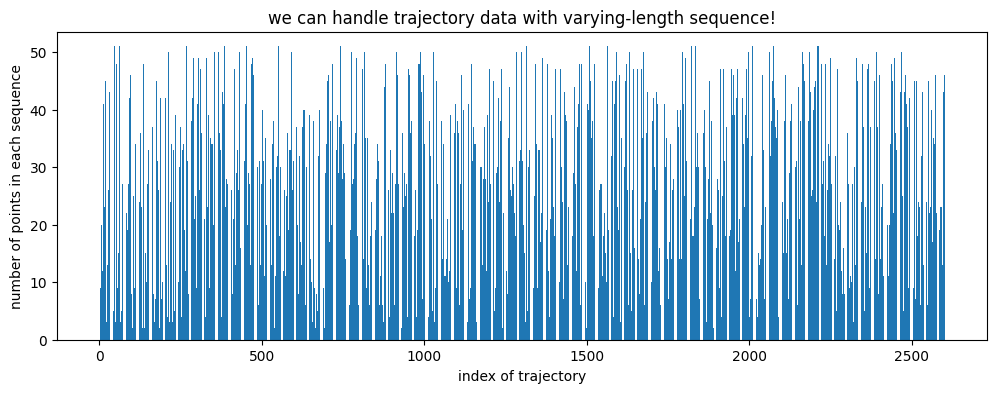

In [4]:
plt.figure(figsize=(12,4))
plt.bar(np.arange(len(traj_list)), [len(x) for x in traj_list])
plt.xlabel('index of trajectory')
plt.ylabel('number of points in each sequence')
plt.title('we can handle trajectory data with varying-length sequence!')

### Now, we call NNDMD as our model

- Note that we call `look_forward=50`, which means our model can **at most** handle data sequence with 51 points.
- If the data sequence contain more than 51 points, if can still set `look_forward=50`, or even smaller number. 
- But you cannot set `look_forward` to be larger than the `length_of_longest_sequence`

In [5]:
look_forward = 50
dlk_regressor = pk.regression.NNDMD(dt=nonlinear_sys.dt, look_forward=look_forward,
                                    config_encoder=dict(input_size=2,
                                                        hidden_sizes=[32] * 3,
                                                        output_size=3,
                                                        activations="swish"),
                                    config_decoder=dict(input_size=3, hidden_sizes=[],
                                                        output_size=2, activations="linear"),
                                    batch_size=512, lbfgs=True,
                                    normalize=True, normalize_mode='equal',
                                    normalize_std_factor=1.0,
                                    trainer_kwargs=dict(max_epochs=3))

### Just like before, use `.fit`

In [6]:
dlk_regressor.fit(traj_list)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                    | Params
----------------------------------------------------------------
0 | _encoder            | FFNN                    | 2.3 K 
1 | _decoder            | FFNN                    | 6     
2 | _koopman_propagator | StandardKoopmanOperator | 9     
3 | masked_loss_metric  | MaskedMSELoss           | 0     
----------------------------------------------------------------
2.

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Now, with recurrent loss minimized, eigenvalues matches perfectly

In [7]:
eigv = np.log(dlk_regressor.eigenvalues_)/nonlinear_sys.dt
print(eigv)

[-0.999272   -0.20037632 -0.09994998]


### Testing on unseen trajectory

In [8]:
x0 = np.array([2, -4])  #np.array([2, -4])
T = 20
t = np.arange(0, T, nonlinear_sys.dt)
Xtest = nonlinear_sys.simulate(x0[:, np.newaxis], len(t)-1).T
Xtest = np.vstack([x0[np.newaxis, :], Xtest])

Xkoop_nn = dlk_regressor.simulate(x0[np.newaxis, :], n_steps=len(t)-1)

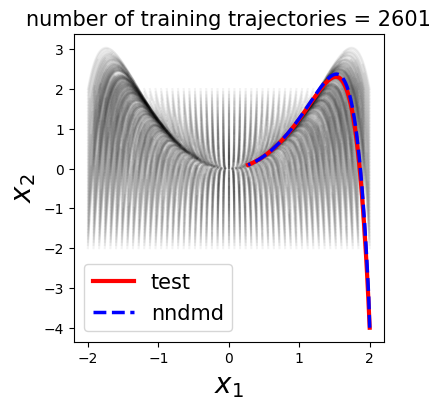

In [9]:
plt.figure(figsize=(4,4))
for i in range(len(traj_list)):
    plt.plot(traj_list[i][:,0],traj_list[i][:,1],'-k',alpha=0.05)
plt.plot(Xtest[:,0],Xtest[:,1],'-r',lw=3,label='test')
plt.plot(Xkoop_nn[:,0],Xkoop_nn[:,1],'--b',lw=2.5,label='nndmd')

plt.xlabel(r"$x_1$",size=20)
plt.ylabel(r"$x_2$",size=20)
plt.title(f"number of training trajectories = {len(traj_list)}",size=15)
plt.legend(loc='best',fontsize=15)

### We can check out the transformation $\phi_i(x)$

In [10]:
# create some grid
n_pts = 501
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))

In [11]:
# compute the transformation (real numbers)
transf = dlk_regressor._compute_phi(Xdat.T)

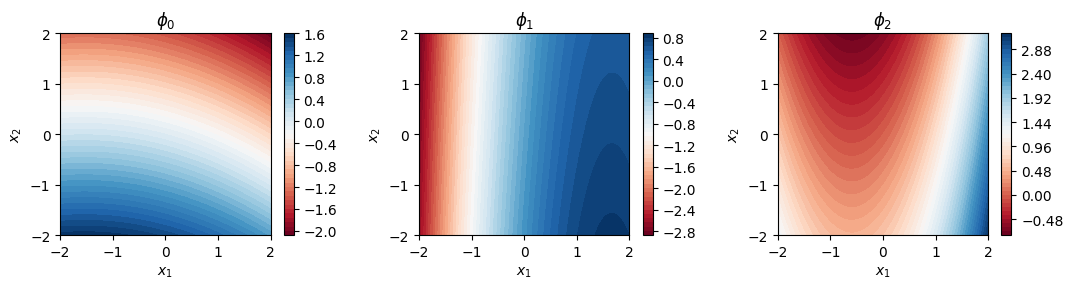

In [12]:
fig,axs=plt.subplots(1,3,figsize=(11,3))
for i in range(3):
    im = axs[i].contourf(xx,yy,transf[i].reshape(n_pts, n_pts),cmap='RdBu',levels=50)
    axs[i].set_title(f"$\phi_{i}$")
    axs[i].set_xlabel(r"$x_1$")
    axs[i].set_ylabel(r"$x_2$")
    fig.colorbar(im,ax=axs[i])
plt.tight_layout()

### More interestingly, we can also check out the eigenfunctions $\psi_i(x)$

In [13]:
# create some grid
n_pts = 501
xmin = ymin = -2
xmax = ymax = +2
xx, yy = np.meshgrid(np.linspace(xmin,xmax, n_pts), np.linspace(ymin, ymax, n_pts))
Xdat = np.vstack((xx.flatten(), yy.flatten()))

In [14]:
# compute the eigenfunction
eigf = dlk_regressor._compute_psi(Xdat.T)

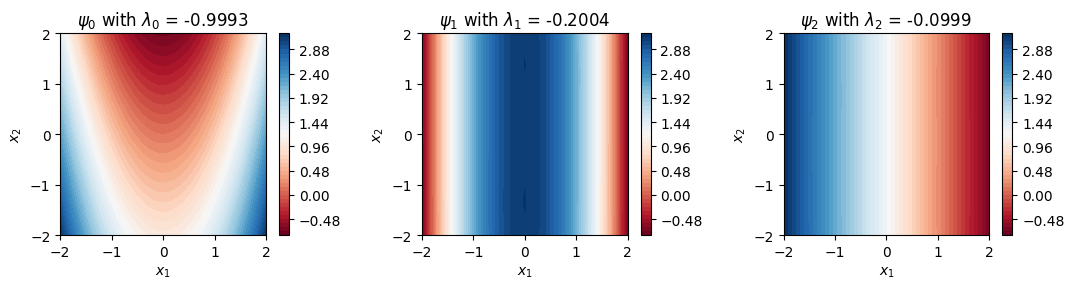

In [15]:
fig,axs=plt.subplots(1,3,figsize=(11,3))
for i in range(3):
    axs[i].contourf(xx,yy,eigf[i].reshape(n_pts, n_pts),cmap='RdBu',levels=50)
    axs[i].set_title(f"$\psi_{i}$ with $\lambda_{i}$ = {eigv[i]:.4f}")
    axs[i].set_xlabel(r"$x_1$")
    axs[i].set_ylabel(r"$x_2$")
    fig.colorbar(im,ax=axs[i])
plt.tight_layout()

### We can also get the mapping that maps $\phi(x)$ back to $x$, so let's verify $x=C\phi(x)$

In [16]:
# just consider random state x, let's verify we can get x back
x = np.random.rand(100,2)*2-1
phi = dlk_regressor._compute_phi(x)
x_rec = dlk_regressor.C @ phi

# verification using 0.1% deviation error as criterion
assert np.linalg.norm(x_rec-x.T)/np.linalg.norm(x) < 1e-3

### Next, let's verify $x = V \psi(x)$

In [17]:
x = np.random.rand(100,2)*2-1
psi = dlk_regressor._compute_psi(x)
x_rec = dlk_regressor.V  @ psi

# verification using 0.1% deviation error as criterion
assert np.linalg.norm(x_rec-x.T)/np.linalg.norm(x) < 1e-3